# Purchase Clustering and Hourly Review
- The dataset contains purchase (ticket, receipt) info with timestamps, product name and unit price.
- This notebook shows ...
    - Data sanitizing
    - Segmenting receipt by per-ticket value and product basket
    - and plots on those with categories and datetime stamps

# Methods

## Load Libraries and Dataset

In [1]:
import os.path as path
import numpy as np
import pandas as pd

from scipy.stats import (
    zscore
)
from sklearn.preprocessing import KBinsDiscretizer
from mlxtend.frequent_patterns import (
    apriori,
    association_rules
)

import matplotlib.pyplot as plt
import seaborn as sns

_weekday_name_map={
    0:'Monday',
    1:'Tuesday',
    2:'Wedsday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'
}

# dataset_path='/kaggle/input/french-bakery-daily-sales/Bakery sales.csv'
dataset_path='o:/yuninze/code/Bakery sales.csv'
dataset_org=pd.read_csv(dataset_path).drop('Unnamed: 0',axis=1)

## Preprocessing: Sanitization
- Timestamps were parsed to per-unit columns, and string columns were cleaned with methods.
- Processed columns (series) were concatenated with explicit type casting.

In [2]:
ticket=dataset_org.ticket_number.astype('u4').astype('str')

datetime=pd.to_datetime(
    dataset_org.loc[:,['date','time']].agg(' '.join,axis=1),
    format='%Y-%m-%d %H:%M'
)

date=pd.to_datetime(
    dataset_org.loc[:,'date'],
    format='%Y-%m-%d'
)

dateQuarter=date.dt.quarter.map(
    lambda q: f'Q{q}'
).astype('str')

dateMonth=date.dt.month

dateDay=date.dt.weekday.map(
    lambda q: _weekday_name_map[q]
).astype('str')

time=pd.to_datetime(dataset_org.loc[:,'time'],format='%H:%M')
timeHour=time.dt.hour.astype('u4')
timeMinute=time.dt.minute.astype('u4')

article=dataset_org.loc[:,'article'].str.strip().str.lower().str.title()

qty=dataset_org.loc[:,'Quantity'].astype('i4')
price=dataset_org.loc[:,'unit_price'].str.replace(',','.').str.replace(' €','').astype('f4')
value=qty * price

dataset=pd.concat([
    ticket,
    datetime,
    date,
    dateQuarter,
    dateMonth,
    dateDay,
    time,
    timeHour,
    timeMinute,
    article,
    qty,
    price,
    value
],axis=1).set_axis([
    'ticket',
    'datetime',
    'date',
    'dateQuarter',
    'dateMonth',
    'dateDay',
    'time',
    'timeHour',
    'timeMinute',
    'article',
    'qty',
    'price',
    'value'
],axis=1)

## Preprocessing: Product Names
- 'article' column contains product names.
    - There's a rational way to get product categories (e.g. drinks, breads, pastries). <ins>[Refer to this notebook](https://www.kaggle.com/code/teawithlemon/analyzing-french-bakery-sales-part-i).</ins>
- I'm going to drop tickets with seasonal products (occurs 4>times only) and refunded products (quantity<0).
    - This is because I'm going to categorize the purchases by ticket, and small portion of conditional expression might be a noise.

In [3]:
article_nominal_name={
    r'Boule.*':'Boule',
    r'Tarte Fruits.*':'Tarte Fruits',
    r'Royal.*':'Royal'
}

dataset=dataset.replace(
    {'article':article_nominal_name},
    regex=True
)

In [4]:
article_seasonal_check=dataset.groupby('article').dateQuarter.nunique()
article_seasonal=article_seasonal_check[article_seasonal_check!=4].index.to_list()

ticket_seasonal=dataset.loc[dataset.article.isin(article_seasonal)].ticket.to_list()
ticket_seasonal_sieve=~dataset.ticket.isin(ticket_seasonal)

In [5]:
ticket_refunded=dataset.loc[dataset.qty<0].ticket.to_list()
row_refunded=dataset.loc[dataset.ticket.isin(ticket_refunded)]
row_refunded_check=(row_refunded.groupby(['ticket','article']).qty.sum()<0).value_counts()

ticket_refunded_sieve=~dataset.ticket.isin(ticket_refunded)

In [ ]:
# dataset without seasonal articles and refunded tickets
dataset_sieved=dataset.loc[ticket_seasonal_sieve & ticket_refunded_sieve]
dataset_sieved.head(3)

,ticket,datetime,date,dateQuarter,dateMonth,dateDay,time,timeHour,timeMinute,article,qty,price,value
0,150040,2021-01-02 08:38:00,2021-01-02,Q1,1,Saturday,1900-01-01 08:38:00,8,38,Baguette,1,0.9,0.9
1,150040,2021-01-02 08:38:00,2021-01-02,Q1,1,Saturday,1900-01-01 08:38:00,8,38,Pain Au Chocolat,3,1.2,3.6
2,150041,2021-01-02 09:14:00,2021-01-02,Q1,1,Saturday,1900-01-01 09:14:00,9,14,Pain Au Chocolat,2,1.2,2.4


## Preprocessing: Binning by Per-ticket Revenue
- I'm going to binning per-ticket revenue.

In [ ]:
ticket_value=dataset_sieved.loc[:,['ticket','value']].groupby('ticket',as_index=False).sum()
ticket_value.head(3)

,ticket,value
0,150040,4.50
1,150041,3.55
2,150042,6.00


In [ ]:
discretizer=KBinsDiscretizer(n_bins=4,encode='ordinal',subsample=None)

ticket_value=ticket_value.assign(
    valueType=(
        discretizer.fit_transform(ticket_value[['value']]).astype('u4').astype('str')
    )
)

dataset_sieved_merged=dataset_sieved.merge(
    ticket_value.loc[:,['ticket','valueType']],
    on='ticket',
    how='left'
)

dataset_sieved_merged.head(3)

,ticket,datetime,date,dateQuarter,dateMonth,dateDay,time,timeHour,timeMinute,article,qty,price,value,valueType
0,150040,2021-01-02 08:38:00,2021-01-02,Q1,1,Saturday,1900-01-01 08:38:00,8,38,Baguette,1,0.9,0.9,2
1,150040,2021-01-02 08:38:00,2021-01-02,Q1,1,Saturday,1900-01-01 08:38:00,8,38,Pain Au Chocolat,3,1.2,3.6,2
2,150041,2021-01-02 09:14:00,2021-01-02,Q1,1,Saturday,1900-01-01 09:14:00,9,14,Pain Au Chocolat,2,1.2,2.4,2


## Preprocessing: Item Basket and Item Popularity
- Here, I'm trying to get a basket analysis via mlxtend.
- Item popularity (sold count) by per-ticket revenue groups are also created.
- While most expressions in the array are 0 (= not enough number of product selling events), association rules will still show some interaction between the products.

In [24]:
ticket_basket=dataset_sieved_merged.pivot_table(
    values='qty',
    index='ticket',
    columns='article',
    aggfunc='sum',
    fill_value=0
)
ticket_basket=ticket_basket.where(ticket_basket==0, 1)

ticket_basket.head(3)

article,Baguette,Baguette Apero,Baguette Graine,Banette,Banettine,Boisson 33Cl,Boule,Brioche,Briochette,Brownies,...,Sucette,Tarte Fine,Tarte Fruits,Tartelette,The,Traditional Baguette,Traiteur,Tropezienne,Tropezienne Framboise,Vik Bread
ticket,,,,,,,,,,,,,,,,,,,,,
150040,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150042,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [25]:
ticket_basket_compressed=ticket_basket.iloc[:,:-1].merge(
    dataset_sieved_merged.loc[:,['ticket','valueType']].drop_duplicates(),
    how='left',
    on='ticket'
).drop('ticket',axis=1).groupby('valueType').mean()

ticket_expression_norm=pd.DataFrame(
    data=zscore(ticket_basket_compressed.to_numpy('f4')),
    index=ticket_basket_compressed.index,
    columns=ticket_basket_compressed.columns,
).T

ticket_expression_norm.head(3)

valueType,0,1,2,3
Baguette,1.644060,-0.081309,-0.595145,-0.967605
Baguette Apero,-0.963132,-0.963132,0.582669,1.343596
Baguette Graine,-1.549249,-0.200358,0.995470,0.754137


In [26]:
def sellcount(q): return np.count_nonzero(q.to_numpy('i4'))

ticket_basket.agg(
    ['median','mean',sellcount]
).T.sort_values('sellcount', ascending=False).head(5).style.format('{:.2f}')

,median,mean,sellcount
article,,,
Traditional Baguette,0.00,0.50,65793.00
Coupe,0.00,0.14,18883.00
Baguette,0.00,0.11,14992.00
Banette,0.00,0.11,14730.00
Croissant,0.00,0.08,11106.00


In [27]:
frequent_item=apriori(
    ticket_basket.astype('bool'),
    min_support=5e-3,
    use_colnames=True
)

assoc_rules=association_rules(
    frequent_item,
    metric='leverage',
    num_itemsets=ticket_basket.shape[0],
    min_threshold=-1
).query(
    '(leverage <= 5e-3 * -1) | (leverage >= 5e-3)'
).drop_duplicates('leverage').sort_values('leverage',ascending=False)

assoc_rules.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
22,(Boule),(Coupe),0.052997,0.142779,0.043802,0.826509,5.788713,1.0,0.036236,4.941003,0.873545,0.288223,0.797612,0.566646
52,(Pain Au Chocolat),(Croissant),0.077299,0.083975,0.039598,0.512276,6.100312,1.0,0.033107,1.878163,0.906116,0.325441,0.467565,0.491912
28,(Campagne),(Coupe),0.028755,0.142779,0.022971,0.798843,5.594947,1.0,0.018865,4.261451,0.845582,0.154621,0.765338,0.479864


# Results

## Hourly Revenue by Quarter: Scatter
- The scatterplot shows tendency between ticket revenue and types with additional categories.

In [29]:
dataset_ready=dataset_sieved_merged.groupby(
    ['ticket','datetime','dateQuarter','dateDay','timeHour','valueType'],
    as_index=False
)['value'].sum()

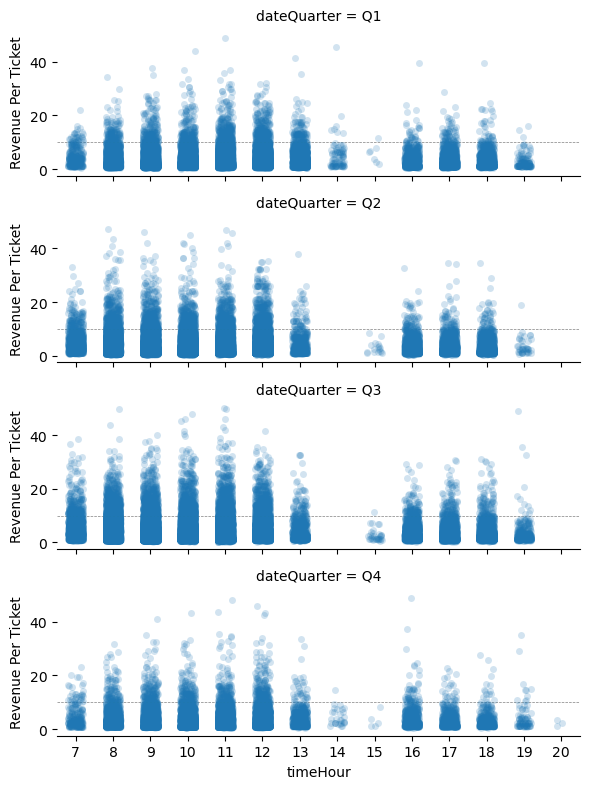

In [30]:
graph=sns.catplot(
    kind='strip',
    
    data=dataset_ready.query('value <= 50'),
    x='timeHour',
    y='value',
    
    row='dateQuarter',
    row_order=['Q1','Q2','Q3','Q4'],
    
    jitter=.2,
    alpha=.2,
    legend=False,
    
    height=2,
    aspect=3
)

graph.refline(y=10, color='#000000', linewidth=.5, linestyle='dashed', alpha=.5)
graph.set(ylabel='Revenue Per Ticket')
graph.despine(left=True)

## Hourly Reveune by Quarter: Lineplot

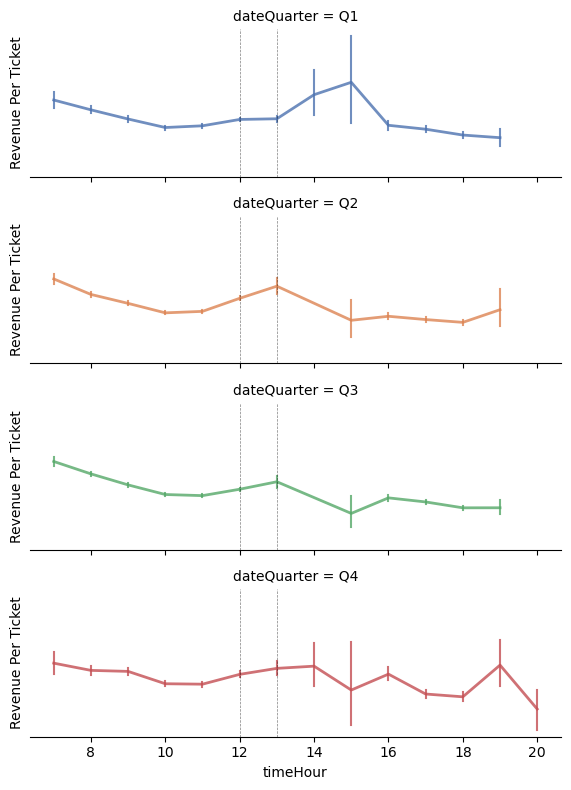

In [31]:
graph=sns.relplot(
    kind='line',
    
    data=dataset_ready.query('value <= 50'),
    x='timeHour',
    y='value',
    
    row='dateQuarter',
    row_order=['Q1','Q2','Q3','Q4'],
    
    hue='dateQuarter',

    err_style='bars',
    n_boot=3000,

    linewidth=2,
    palette='deep',
    alpha=.8,
    legend=None,
    
    height=2,
    aspect=3
)

graph.refline(x=12, color='#000000', linewidth=.5, linestyle='dashed', alpha=.5)
graph.refline(x=13, color='#000000', linewidth=.5, linestyle='dashed', alpha=.5)
graph.set(ylabel='Revenue Per Ticket',yticks=[])
graph.despine(left=True)

## Hourly Sell Count by Revenue per Ticket Group and Day

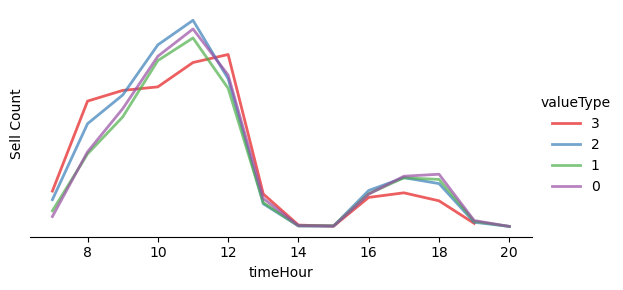

In [32]:
graph=sns.relplot(
    kind='line',
    
    data=dataset_ready.groupby(
        ['timeHour','valueType'],
        as_index=False
    )['ticket'].size(),
    x='timeHour',
    y='size',
    
    hue='valueType',
    hue_order=list('3210'),
    
    linewidth=2,
    palette='Set1',
    alpha=.7,
    legend='full',
    
    height=3,
    aspect=2
)

graph.set(yticks=[],ylabel='Sell Count')
graph.despine(left=True)

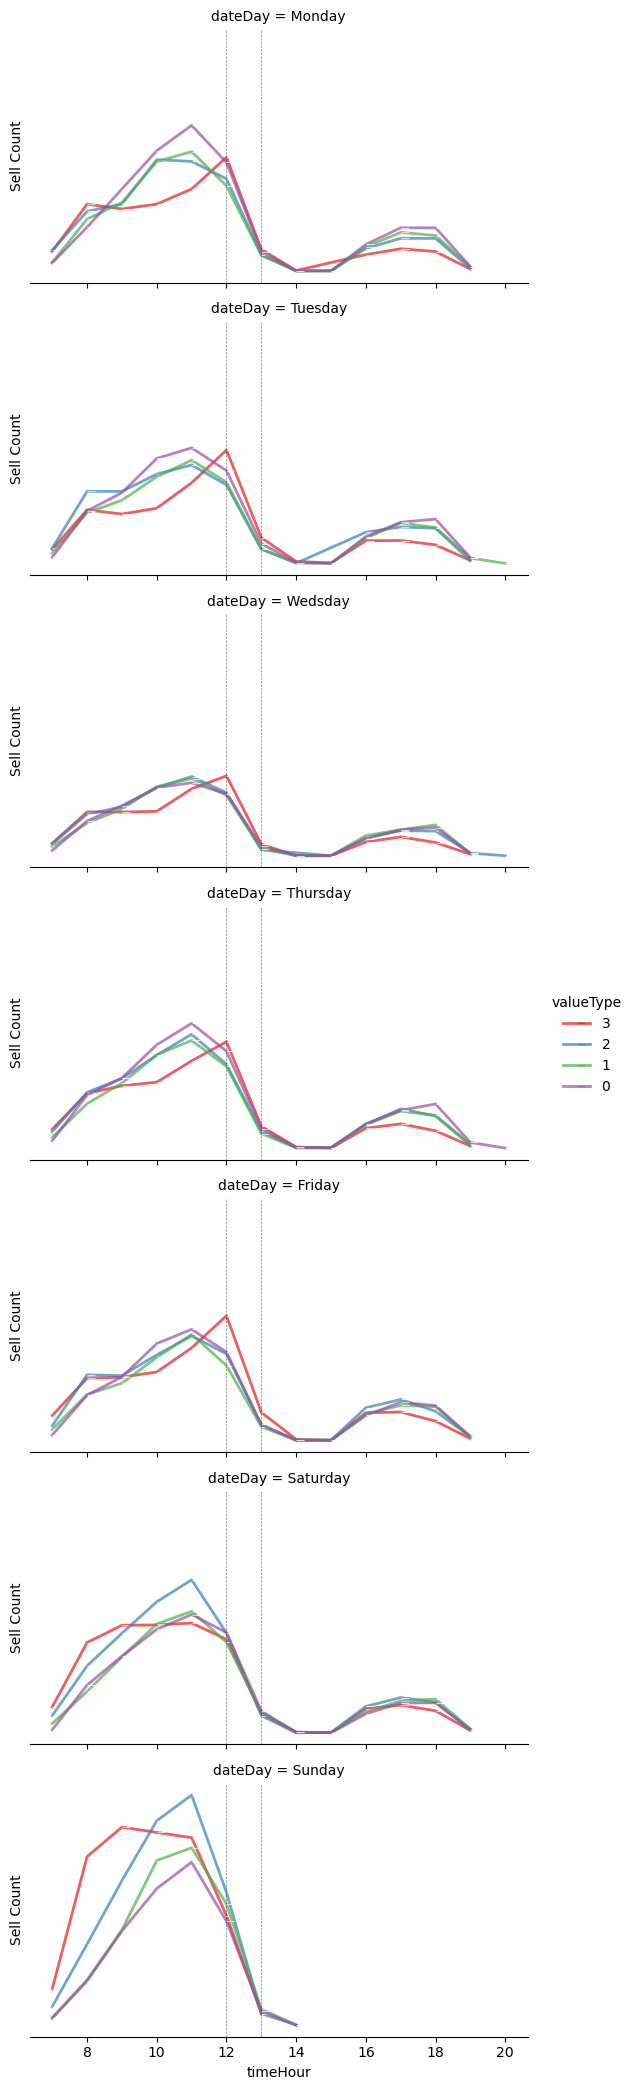

In [33]:
graph=sns.relplot(
    kind='line',
    
    data=dataset_ready.groupby(
        ['dateDay','timeHour','valueType'],
        as_index=False
    )['ticket'].size(),
    x='timeHour',
    y='size',

    row='dateDay',
    row_order=_weekday_name_map.values(),
    
    hue='valueType',
    hue_order=list('3210'),

    marker=True,
    
    linewidth=2,
    palette='Set1',
    alpha=.7,
    legend='full',
    
    height=3,
    aspect=2
)

graph.refline(x=12, color='#000000', linewidth=.5, linestyle='dashed', alpha=.5)
graph.refline(x=13, color='#000000', linewidth=.5, linestyle='dashed', alpha=.5)
graph.set(yticks=[],ylabel='Sell Count')
graph.despine(left=True)

## Item Popularity by Per-ticket Revenue, Behavior Flow

In [34]:
ticket_expression_norm.style.format('{:.1f}').bar(subset=ticket_expression_norm.columns.to_list(),color='#d68f8f')

valueType,0,1,2,3
Baguette,1.6,-0.1,-0.6,-1.0
Baguette Apero,-1.0,-1.0,0.6,1.3
Baguette Graine,-1.5,-0.2,1.0,0.8
Banette,1.6,0.1,-0.8,-0.9
Banettine,1.1,0.9,-1.0,-1.0
Boisson 33Cl,-1.0,-0.6,-0.1,1.6
Boule,-1.5,1.1,0.6,-0.2
Brioche,-0.6,-0.6,-0.6,1.7
Briochette,-1.0,-0.7,0.0,1.6
Brownies,-0.9,-0.9,0.2,1.6


In [35]:
item_behavior_flow=pd.concat([
    assoc_rules.loc[:,['antecedents','consequents']].map(
        lambda q: ', '.join([w for w in q])
    ).agg(
        lambda q: ' -> '.join(q), axis=1
    ),
    assoc_rules.loc[:,'leverage']
],axis=1).set_axis(
    ['Item Behavior Flow','Coefficient'],axis=1).set_index(
    'Item Behavior Flow',drop=True
)

item_behavior_flow.style.format('{:.2f}').bar(subset=['Coefficient'],color='#d68f8f')

,Coefficient
Item Behavior Flow,
Boule -> Coupe,0.04
Pain Au Chocolat -> Croissant,0.03
Campagne -> Coupe,0.02
Special Bread -> Coupe,0.02
"Pain Au Chocolat, Traditional Baguette -> Croissant",0.01
Complet -> Coupe,0.01
"Croissant, Traditional Baguette -> Pain Au Chocolat",0.01
Vik Bread -> Coupe,0.01
Moisson -> Coupe,0.01


# Conclusion

- It's unclear